# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [31]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend , plot_edges_and_points
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics.pairwise import euclidean_distances
import sklearn.metrics as skm
import numpy as np
from skimage import io
import scipy
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import os
import networkx as nx
from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from sklearn.cluster import KMeans
from sklearn.metrics import  adjusted_rand_score


## Generating the data

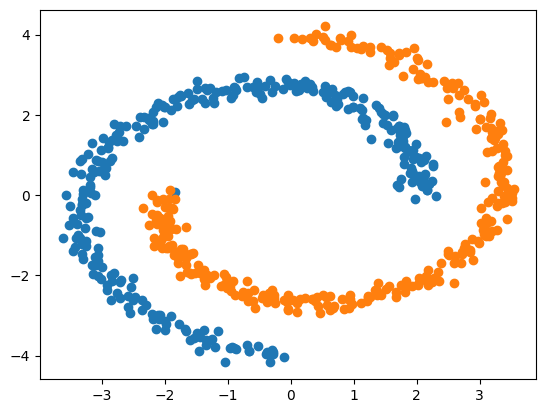

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      ~/Desktop/Spectral_Clustering/generate_data.py
Type:      function


In [14]:
# Example

for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [15]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    n = X.shape[0]
    W = np.zeros((n, n))

    # Compute pairwise euclidean distances and then compute similarities
    distances = euclidean_distances(X, X)
    similarities = np.exp(-distances**2 / (2 * var))

    if k == 0:
        # Epsilon graph
        W = np.where(similarities >= eps, similarities, 0)
    else:
        # kNN graph, ensuring it's undirected
        neigh = NearestNeighbors(n_neighbors=k+1).fit(X)
        distances, indices = neigh.kneighbors(X)
        
        for i in range(n):
            for j in indices[i][1:]:  # Skip the first one (self)
                # Ensure the graph is undirected
                W[i, j] = similarities[i, j]
                W[j, i] = similarities[j, i]

    np.fill_diagonal(W, 0)  # Remove self-similarities
    return W


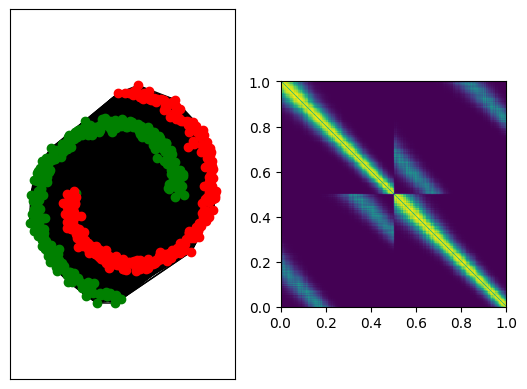

In [16]:
W= build_similarity_graph(X, var=1, eps=0, k=0)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [17]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization,
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """

    # Degree matrix D
    D = np.diag(W.sum(axis=1))
    
    # Unnormalized Laplacian
    L_unn = D - W

    if laplacian_normalization == 'unn':
        L = L_unn
    elif laplacian_normalization == 'sym':
        # Symmetric normalized Laplacian: L_sym = D^(-1/2) * L_unn * D^(-1/2)
        D_inv_sqrt = np.diag(1.0 / np.sqrt(W.sum(axis=1)))
        L = np.matmul(np.matmul(D_inv_sqrt, L_unn), D_inv_sqrt)
    elif laplacian_normalization == 'rw':
        # Random-walk normalized Laplacian: L_rw = D^(-1) * L_unn
        D_inv = np.diag(1.0 / W.sum(axis=1))
        L = np.matmul(D_inv, L_unn)
    else:
        raise ValueError("Invalid laplacian_normalization. Choose 'unn', 'sym', or 'rw'.")

    return L

## Clustering

In [52]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    eigenvalue, eigenvector = scipy.linalg.eig(L)
    eigenvalue, eigenvector = eigenvalue.real, eigenvector.real # convert it to real numbers
    rang = eigenvalue.argsort()
    eigenvalue = eigenvalue[rang]
    E = eigenvector[:,rang]
    U = np.diag(eigenvalue)
                   
  
    if chosen_eig_indices == None:
        chosen_eig_indices = list(range(num_classes+1))

    kmeans = KMeans(n_clusters=num_classes)
    X = E[:, chosen_eig_indices]
    Y = kmeans.fit_predict(X)
    return Y




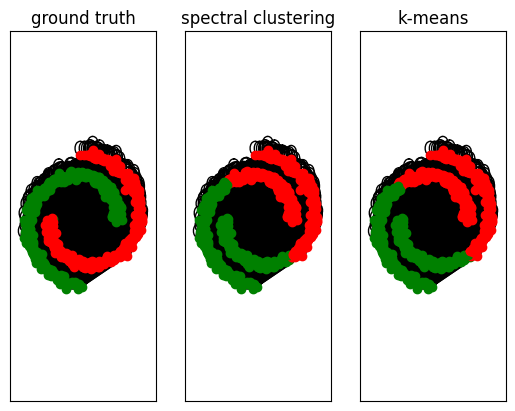

In [19]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [20]:
def parameter_sensitivity():
    num_samples = 500
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None 

    # Generate data
    X, Y = two_moons(num_samples)  

    """
    Choose candidate parameters for 'k' and 'eps'
    """
    k_candidates = np.arange(1 , 51 , 10)
    eps_candidates = np.arange(0.1, 1.1, 0.1)  # Epsilon values from 0.1 to 1 with a step of 0.1

    # Placeholder for performance tracking
    performance_k = []
    performance_eps = []

    # Evaluate performance for 'k'
    for k in k_candidates:
        W = build_similarity_graph(X, var=var, k=k)  
        L = build_laplacian(W, laplacian_normalization)  
        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=2) 
        performance_k.append(skm.adjusted_rand_score(Y, Y_rec))

    # Evaluate performance for 'eps'
    for eps in eps_candidates:
        W = build_similarity_graph(X, var=var, eps=eps)
        L = build_laplacian(W, laplacian_normalization)
        if np.isnan(L).any() or np.isinf(L).any():
            print(f"Skipping eps={eps} due to invalid Laplacian.")
            continue  # Skip this iteration and proceed with the next value of epsilon
        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=2)
        performance_eps.append(skm.adjusted_rand_score(Y, Y_rec))

    # Plotting
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_candidates, performance_k, marker='o')
    plt.xlabel('k')
    plt.ylabel('Adjusted Rand Index')
    plt.title('Performance Sensitivity to k')

    plt.subplot(1, 2, 2)
    plt.plot(eps_candidates, performance_eps, marker='o')
    plt.xlabel('epsilon')
    plt.ylabel('Adjusted Rand Index')
    plt.title('Performance Sensitivity to epsilon')

    plt.tight_layout()
    plt.show()

## Image segmentation

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

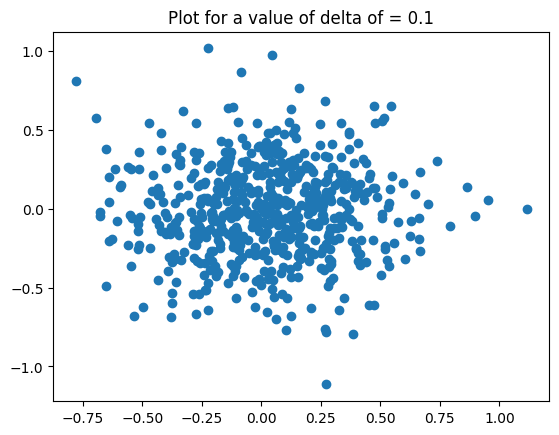

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

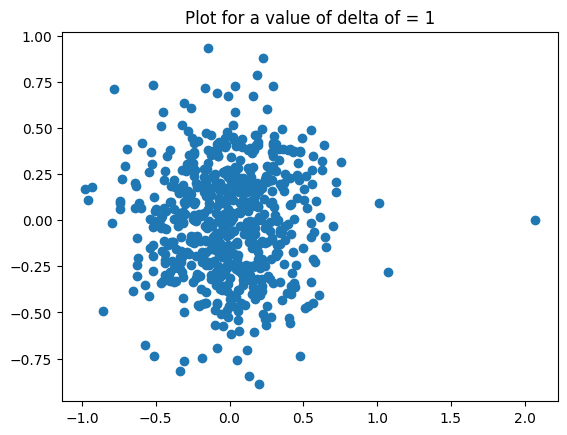

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

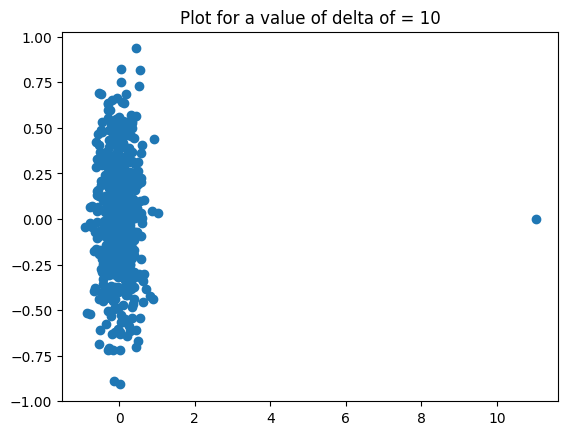

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

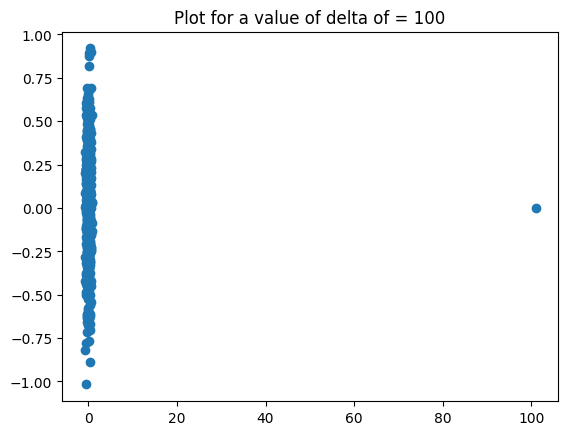

In [21]:
DELTA = [0.1 , 1 , 10 , 100]
for delta in DELTA:
    X, Y = worst_case_blob(600, delta=delta)
    plot_clusters(X, Y)
    print(Y)
    plt.title(f'Plot for a value of delta of = {delta}')
    plt.show()


# ANSWER 1

Worst_case_blob is a function that generates a data set which is two dimenseional array and and an array of boolean that represent the vector of the cluster assignement. The more the value of the delta is big the more, the points who had the biggest value in the X axis is going to be far away from the other points of the data set. This point is going to be an outlier by answering to the second question we can make an hypothesis on why this is called the worst case. Also the more the value of the delta is big the more the point are going to be close to each other except the outlier.   

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

# ANSWER 2

In [22]:
delta_values = [0.1, 1, 5]

for delta in delta_values:
    # Generate data points and labels
    X, Y = worst_case_blob(600, delta=delta)
    
    # Build the initial similarity graph
    W_initial = build_similarity_graph(X, eps=0, k=0)
    
    # Compute the maximum spanning tree directly from the negative similarity graph
    # This approach assumes build_similarity_graph returns a dense matrix, adjust if it's sparse
    min_tree = min_span_tree(-W_initial)
    
    # Determine the smallest edge weight in the max spanning tree to use as eps
    eps = np.min(W_initial[min_tree])
    
    # Rebuild the similarity graph with the determined eps, ensuring connectivity
    W = build_similarity_graph(X, eps=eps, k=0)
    
    # Check if the graph is fully connected
    n_components = scipy.sparse.csgraph.connected_components(W, return_labels=False)
    if n_components == 1:
        # Calculate sparsity as the percentage of zero elements
        sparsity = (W == 0).mean() * 100  
        
        print(f"delta = {delta}")
        print(f"The sparsity of the similarity matrix is {sparsity}%")


delta = 0.1
The sparsity of the similarity matrix is 68.75777777777778%
delta = 1
The sparsity of the similarity matrix is 7.239444444444445%
delta = 5
The sparsity of the similarity matrix is 0.4988888888888889%


Here the overal idea is the the following one. We know that the distribution of our data set is governed by the parameter detlta. We start by doing initaly a similarity graph using the dataset X and with no parameters. This represents the initialisation step. After that using the the maximum spanning tree we seek to get the tree connecting all points such that the sum of edges is maximized which is equivalent to miminimizing similarity for the tree's contruction but keeping always the graph is fully connected. Once we have that we identify the nimumn edge weight in the maxmimum spanning treee as our parameter epsilon that will allow us to create a graph that is fully connected but with the maximum spartisity. We provide after that the level of sparsity for each value of delta. 
Here it seems like with a high value of delta the sparsity is very low. This can be understood as all the points are close to each other in comparaison to the other cases were the points are distributed in an uniform way over a larger range. Hence with the similarity distance between points is going to be bigger and hence the similarity score is going to be easily under the threshold


### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

The graph should be fully connected because if the graph is not fully connected we need to perform as many spectral clustering as we have independent component. Before doing any execution on the code here are some informations that we could take into consideration. In the case of an episilon graph if we pich a value of epsilon that is too small we may end up with a similarity matrix that is equal to the null matrix. With the KNN we will never found ourself in this disposition however if we pick a big value of k we may end up with a graph density that is too big. We want now to try to find a way to compare the time it recquires to get a K-NN graph and an epsilon graph.

In [23]:
def is_fully_connected(W):
    """
    Check if the graph represented by the adjacency matrix W is fully connected.
    """
    G = nx.from_numpy_array(W)
    return nx.is_connected(G)


In [24]:
import time

In [25]:
def find_minimum_k(X, var=1.0, k_range=(1, 20)):
    """
     Iterates over epsilon values of k to find the minimum k that results in a fully connected graph.
    """
   

 
    start_time = time.time()
    min_k = None
    for k in range(*k_range):
        W_knn =  build_similarity_graph(X, var=1.0, eps=0.0, k=k)
        if is_fully_connected(W_knn):
            min_k = k
            construction_time = time.time() - start_time
            break


    
    return  min_k , construction_time 


In [26]:
def measure_construction_time_k_min(X, k_min, var=1.0):
    """
    Measures the time taken to construct the fully connected graph with the given minimum epsilon.
    """
    start_time = time.time()
    W = build_similarity_graph(X, var=var, eps=0, k=k_min)
    construction_time = time.time() - start_time
    print(f"Time taken to construct the fully connected graph: {construction_time:.4f} seconds")
 

In [27]:
def find_minimum_eps(X, var=1.0, eps_range=(0.01, 1.0), eps_step=0.01):
    """
    Iterates over epsilon values to find the minimum epsilon that results in a fully connected graph.
    """
    start_time = time.time()
    construction_time = None  # Initialize construction_time to ensure it's defined
    for eps in np.arange(eps_range[0], eps_range[1], eps_step):
        W = build_similarity_graph(X, var=var, eps=eps, k=0)
        if is_fully_connected(W):
            construction_time = time.time() - start_time
            return eps, construction_time  # Return the first epsilon and time
    construction_time = time.time() - start_time if construction_time is None else construction_time
    return None, construction_time  # Return None and time if no epsilon found

In [28]:
def measure_construction_time_eps(X, min_eps, var=1.0):
    """
    Measures the time taken to construct the fully connected graph with the given minimum epsilon.
    """
    start_time = time.time()
    W = build_similarity_graph(X, var=var, eps=min_eps, k=0)
    construction_time = time.time() - start_time
    print(f"Time taken to construct the fully connected graph: {construction_time:.4f} seconds")
  

In [29]:
X_Worst_case , Y_Worst_case = worst_case_blob(600, delta=5) #We consider the worse case scenario

In [32]:
k_search_time_W_C  ,  time_to_find_K = find_minimum_k(X_Worst_case, var=1.0, k_range=(1, 20))
print("The minimum K is {} and the time required is {}".format(k_search_time_W_C , time_to_find_K))

The minimum K is 4 and the time required is 0.07619810104370117


In [33]:
measure_construction_time_k_min(X_Worst_case, k_search_time_W_C, var=1.0)

Time taken to construct the fully connected graph: 0.0100 seconds


In [34]:
eps_Worst_Case , time_to_find_eps = find_minimum_eps(X_Worst_case, var=1.0, eps_range=(0, 20.0), eps_step=0.001)
print("The minimum of eps is {} and the time required is {}".format(eps_Worst_Case , time_to_find_eps))

The minimum of eps is 0.0 and the time required is 0.6662626266479492


In [35]:
measure_construction_time_eps(X_Worst_case, eps_Worst_Case, var=1.0)

Time taken to construct the fully connected graph: 0.0085 seconds


In the worse case scenario it took more time to find the right epsilon. Even the slightest value of epsilon allows us to have a connected graph. The time to find the best value of epsilon takes 5 times more so we will use the method with the KNN 

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

We start by thinking about which technics of creating the graph connected to use for that we use the function that we have created before.

In [36]:
X_blobs , Y_blobs = blobs(num_samples=600)

In [37]:
k_search_time_blobs  ,  time_to_find_K = find_minimum_k(X_blobs, var=1.0, k_range=(1, 500))
print("The minimum K is {} and the time required is {}".format(k_search_time_blobs , time_to_find_K))

The minimum K is 300 and the time required is 74.26718068122864


In [38]:
W_bolbs = build_similarity_graph(X_blobs,var=1.0, eps= 0 ,k =300)

In [39]:
L_bolbs = build_laplacian(W_bolbs, laplacian_normalization='unn')

In [53]:
Y_spectral = spectral_clustering(L_bolbs, chosen_eig_indices=[1], num_classes=2)

In [54]:
kmeans_direct = KMeans(n_clusters=2, random_state=42)
Y_kmeans = kmeans_direct.fit_predict(X_blobs)

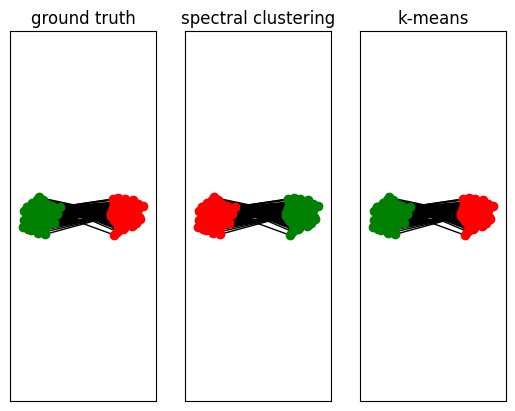

In [55]:
plot_clustering_result(X_blobs , Y_blobs , W_bolbs, Y_spectral, Y_kmeans, normalized_switch=0)

Here we obtain the same results. Here we are not surprised because the disposition of the points. There is no trade off between connectivity and compacity that will lead to contradicting results between the Kmeans and the spectral clustering. The eigenvector that we have used is the first non zero eigenvalues because it represents the fundamental modes of variation within the graph constructed from the data. This mode correspond to the dense regions of the graph and the cuts needed to separate them with minimal cost

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

In [56]:
W_bolbs_2 = build_similarity_graph(X_blobs,var=1.0, eps= 0 ,k =100)

In [57]:
L_bolbs_2 = build_laplacian(W_bolbs_2, laplacian_normalization='unn')

In [58]:
Y_spectral_2 = spectral_clustering(L_bolbs_2, [2], num_classes=2)

In [59]:
kmeans_direct = KMeans(n_clusters=2, random_state=42)
Y_kmeans = kmeans_direct.fit_predict(X_blobs)

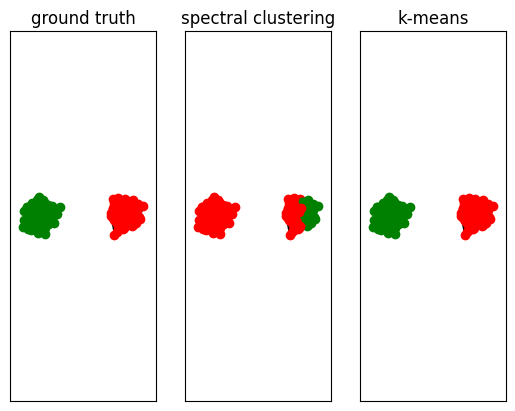

In [60]:
plot_clustering_result(X_blobs , Y_blobs , W_bolbs_2, Y_spectral_2 , Y_kmeans, normalized_switch=0)

In [62]:
Y_spectral_3 = spectral_clustering(L_bolbs_2, [0], num_classes=2)

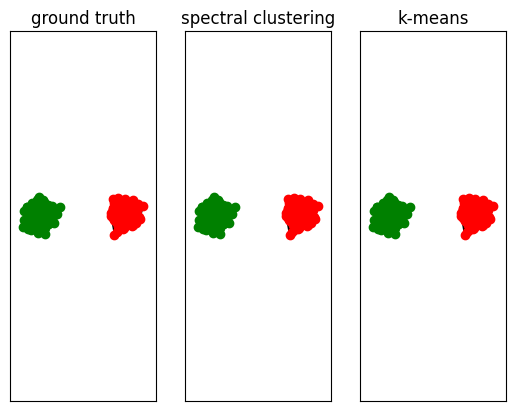

In [63]:
plot_clustering_result(X_blobs , Y_blobs , W_bolbs_2, Y_spectral_3 , Y_kmeans, normalized_switch=0)

It seems like picking the first indices allows us to have the best results however we should take the second non zero indices. Indeed, this eigenvector effectively captures the most significant 'cut' in the data, which, for two well-separated clusters, aligns with the division between these groups but we don't obtain a good result. This may be interprated as the usage of the second non null eigenvector is the one we use for connected graphs while the one we use is not a connected graph

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

In [64]:
def accuracy(Y_truth , Y_Spectral):
    S = 0
    for i in range(len(Y_truth)):
        if Y_truth[i] == Y_Spectral[i]:
            S = S + 1
    acc = (S * 100)/len(Y_truth)
    return acc

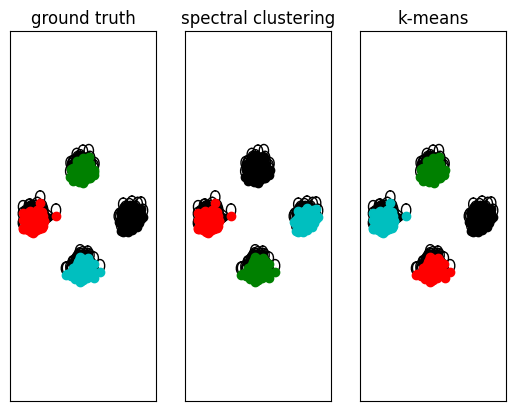

In [74]:
# variance = 0.1
X_var_1 , Y_var_1 = blobs(num_samples=600, n_blobs=4, blob_var=0.1)
W_var_1 = build_similarity_graph(X_var_1, k=50)
L_var_1 = build_laplacian(W_var_1)
Y_spectal_var_1 = spectral_clustering(L_var_1, chosen_eig_indices=None, num_classes=4)
plot_clustering_result(X_var_1, Y_var_1, L_var_1, Y_spectal_var_1, KMeans(4).fit_predict(X_var_1))


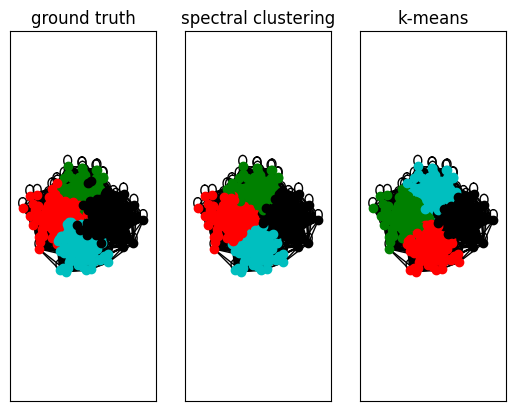

In [75]:
# variance = 0.5
X_var_2 , Y_var_2 = blobs(num_samples=600, n_blobs=4, blob_var=0.5)
W_var_2 = build_similarity_graph(X_var_2, k=50)
L_var_2 = build_laplacian(W_var_2)
Y_spectal_var_2 = spectral_clustering(L_var_2, chosen_eig_indices=None, num_classes=4)
plot_clustering_result(X_var_2, Y_var_2, L_var_2, Y_spectal_var_2, KMeans(4).fit_predict(X_var_2))


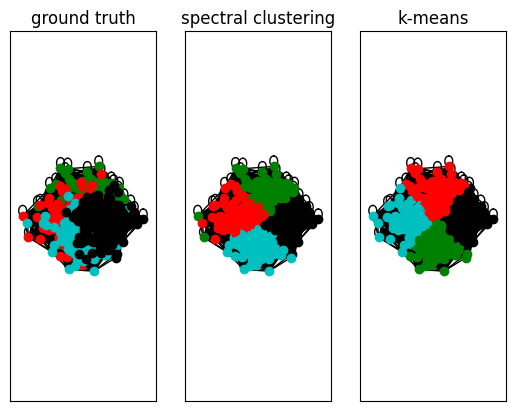

The accuracy  between the ground truth and the KMEANS is for a variance of 1 is accuracy 26.666666666666668
The accuracy between the ground truth and the spectral clustering for a variance of 1 is accuracy 53.5


In [76]:
# variance = 1
X_var_3 , Y_var_3 = blobs(num_samples=600, n_blobs=4, blob_var=1)
W_var_3 = build_similarity_graph(X_var_3, k=50)
L_var_3 = build_laplacian(W_var_3)
Y_spectal_var_3 = spectral_clustering(L_var_3, chosen_eig_indices=None, num_classes=4)
plot_clustering_result(X_var_3, Y_var_3, L_var_3, Y_spectal_var_3, KMeans(4).fit_predict(X_var_3))
print("The accuracy  between the ground truth and the KMEANS is for a variance of 1 is accuracy {}".format(accuracy(Y_var_3  , KMeans(4).fit_predict(X_var_3))))
print("The accuracy between the ground truth and the spectral clustering for a variance of 1 is accuracy {}".format(accuracy(Y_var_3 , Y_spectal_var_3)))

We observe that the variance parameters affects the structure of the of data points. The more the variance is big the more the points are going to be not seperable. For very low values of variance we observe that the data set is seperable the KMEANS relying on conpacity and the spectral clustering relying on the connectivity are going to behave in a similar way. For interdemediate valyes the KMEANS behave better when there still exists a seperation finally when the data set is no longer seperable the KMEANS does not behave well at all. It is logical the KMEANS algorithm is not supposed to work on non seperable data, an intelligent way to perform clustering is to rely on the connectivity of the points instead of their closest neighboor hence we can interpret that the spectral clustering performs better results. When it comes to the strategy that we have adopted is to put directly the number of indices as number of clusters +  1 as we know that in python the number of indices starts with 0. This results is based on some previous knowledge we should have as much components as we have number of classes and the idea is that each eigen vector except the first one the one associated with the eigen value 0 is going to be linked in some ways to the independent components of the graph

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

When building our cluster assignemt we have relied on KMEANS that is an iterative generalization of the thresholding to multiple class problems. In a 2 class cases, the KMEANS sets a threesholding on the basis of minimizing the distance within each cluster. If you are distance to the first centroid is less than your distance to the second centroid you fail into the first cluster and vice versa. The iterative aspects allow you to adjust the pick of the centroid. Plus we can see that the points have a spheric distribution which makes the KMEANS clustering better

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

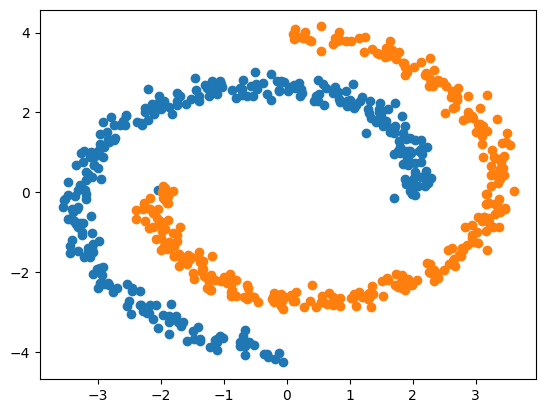

In [131]:
X_Two_Moons , Y_Two_Moons = two_moons(num_samples=600)
plot_clusters(X_Two_Moons, Y_Two_Moons)

In [132]:
k_Two_Moons  ,  time_to_find_K = find_minimum_k(X_Two_Moons, var=1.0, k_range=(1, 500))
print("The minimum K is {} and the time required is {}".format(k_Two_Moons  , time_to_find_K))

The minimum K is 17 and the time required is 0.4588131904602051


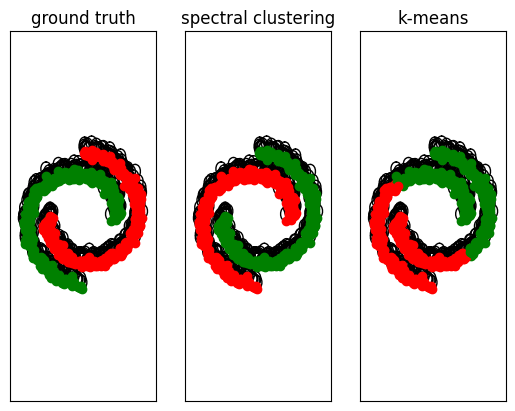

In [136]:
W_Two_Moons = build_similarity_graph(X_Two_Moons, k=17)
L_Two_Moons = build_laplacian(W_Two_Moons)
Y_spectal_Two_Moons = spectral_clustering(L_Two_Moons, chosen_eig_indices=None, num_classes=2)
plot_clustering_result(X_Two_Moons, Y_Two_Moons, L_Two_Moons, Y_spectal_Two_Moons, KMeans(2).fit_predict(X_Two_Moons))


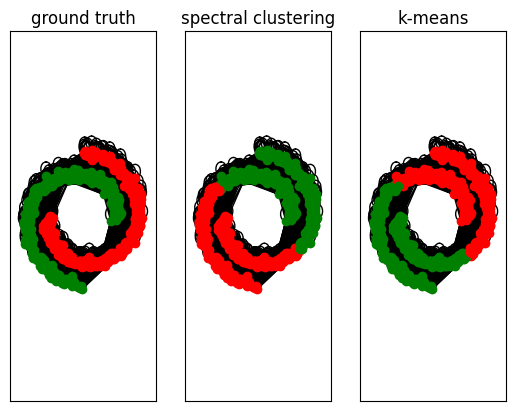

In [137]:
W_Two_Moons_1 = build_similarity_graph(X_Two_Moons, k=150)
L_Two_Moons_1 = build_laplacian(W_Two_Moons_1)
Y_spectal_Two_Moons_1 = spectral_clustering(L_Two_Moons_1, chosen_eig_indices=None, num_classes=2)
plot_clustering_result(X_Two_Moons, Y_Two_Moons, L_Two_Moons_1, Y_spectal_Two_Moons_1, KMeans(2).fit_predict(X_Two_Moons))


The ground truth clustering is not based on proximity between points. We expect the spectral clustering to perform better than the KMEANS. Here however we want to study the effect of the connection in the graph on the results. We observe that if the graph is still not connected or if it's just connected the spectral clustering will perform better indeed the seperation here is based upon the connectivity of the components. The KMEANS will reduce the distances with each clusters making hence a very bad clustering. Two points that are close to each other may not be connected to each other and two points relatively far away if we look at the extermety of each moon are connected and are supposed to be in the same cluster. This is the reason why the KMEANS seems to cut the two moons in half as the centroid of each half moon is the best way to reduce the overal distance within each cluster. There is something interesting here is that if we have a graph that is very much connected the behavior of the spectral clustering decreases indeed we can consider compacity as the extreme case of a graph that is overly connected. 

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

In [98]:
X_Point, Y_Point = point_and_circle(num_samples=600)

In [99]:
k_Point  ,  time_to_find_K = find_minimum_k(X_Point, var=1.0, k_range=(1, 500))
print("The minimum K is {} and the time required is {}".format(k_Point  , time_to_find_K))

The minimum K is 50 and the time required is 2.555880069732666


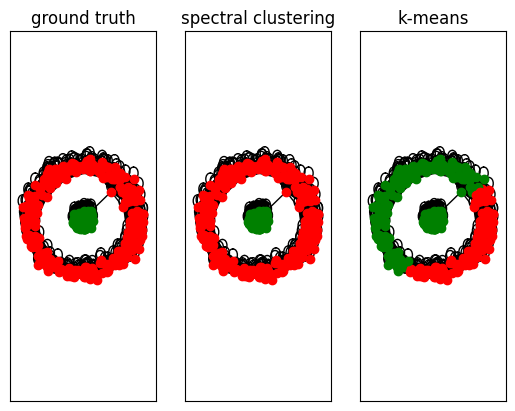

The accuracy between the ground truth and the spectral clustering is accuracy 100.0


In [101]:
W_Point = build_similarity_graph(X_Point, k=50)
L_Point_sym = build_laplacian(W_Point, 'sym')
Y_Point_Spectral_sym = spectral_clustering(L_Point_sym, chosen_eig_indices=None, num_classes=2)
plot_clustering_result(X_Point, Y_Point, L_Point_sym, Y_Point_Spectral_sym, KMeans(2).fit_predict(X_Point))
print("The accuracy between the ground truth and the spectral clustering is accuracy {}".format(accuracy(Y_Point , Y_Point_Spectral_sym)))

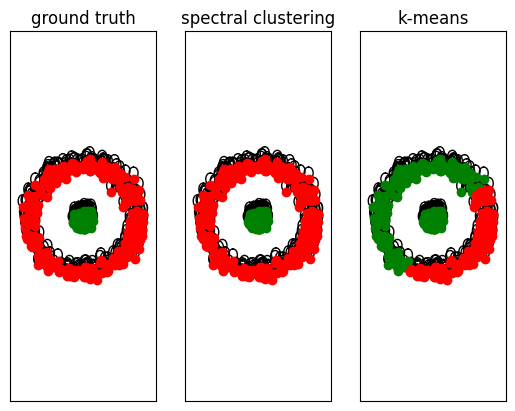

The accuracy between the ground truth and the spectral clustering is accuracy 100.0


In [103]:
W_Point = build_similarity_graph(X_Point, k=10)
L_Point_sym = build_laplacian(W_Point, 'sym')
Y_Point_Spectral_sym = spectral_clustering(L_Point_sym, chosen_eig_indices=None, num_classes=2)
plot_clustering_result(X_Point, Y_Point, L_Point_sym, Y_Point_Spectral_sym, KMeans(2).fit_predict(X_Point))
print("The accuracy between the ground truth and the spectral clustering is accuracy {}".format(accuracy(Y_Point , Y_Point_Spectral_sym)))

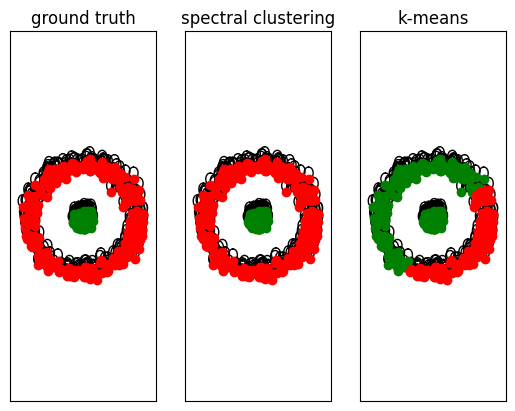

The accuracy between the ground truth and the spectral clustering is accuracy 100.0


In [105]:
W_Point = build_similarity_graph(X_Point, k=10)
L_Point_rw = build_laplacian(W_Point, 'rw')
Y_Point_Spectral_rw = spectral_clustering(L_Point_rw, chosen_eig_indices=None, num_classes=2)
plot_clustering_result(X_Point, Y_Point, L_Point_rw,  Y_Point_Spectral_rw, KMeans(2).fit_predict(X_Point))
print("The accuracy between the ground truth and the spectral clustering is accuracy {}".format(accuracy(Y_Point , Y_Point_Spectral_rw)))

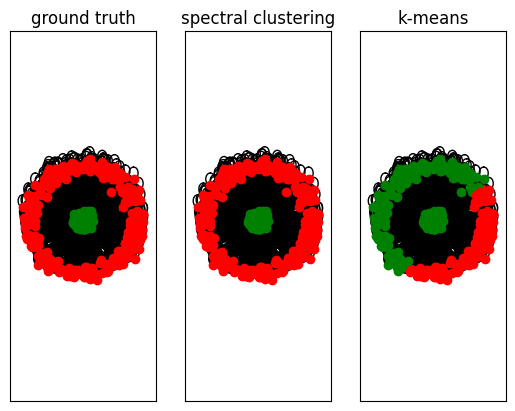

The accuracy between the ground truth and the spectral clustering is accuracy 100.0


In [107]:
W_Point = build_similarity_graph(X_Point, k=100)
L_Point_sym = build_laplacian(W_Point, 'sym')
Y_Point_Spectral_sym = spectral_clustering(L_Point_sym, chosen_eig_indices=None, num_classes=2)
plot_clustering_result(X_Point, Y_Point, L_Point_sym, Y_Point_Spectral_sym, KMeans(2).fit_predict(X_Point))
print("The accuracy between the ground truth and the spectral clustering is accuracy {}".format(accuracy(Y_Point , Y_Point_Spectral_sym)))

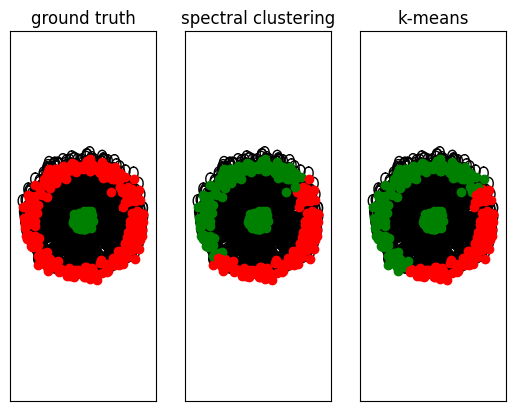

The accuracy between the ground truth and the spectral clustering is accuracy 76.0


In [108]:
W_Point = build_similarity_graph(X_Point, k=100)
L_Point_rw = build_laplacian(W_Point, 'rw')
Y_Point_Spectral_rw = spectral_clustering(L_Point_rw, chosen_eig_indices=None, num_classes=2)
plot_clustering_result(X_Point, Y_Point, L_Point_rw,  Y_Point_Spectral_rw, KMeans(2).fit_predict(X_Point))
print("The accuracy between the ground truth and the spectral clustering is accuracy {}".format(accuracy(Y_Point , Y_Point_Spectral_rw)))

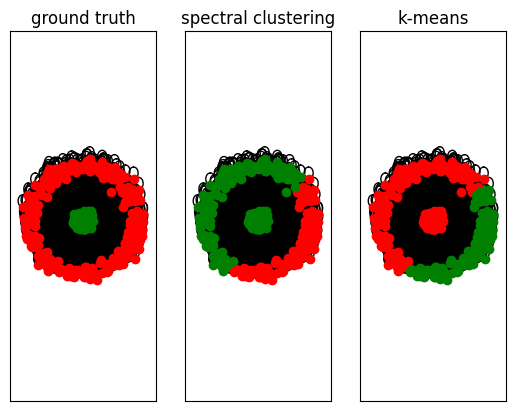

The accuracy between the ground truth and the spectral clustering is accuracy 74.0


In [130]:
W_Point = build_similarity_graph(X_Point, k=200)
L_Point_rw = build_laplacian(W_Point, 'rw')
Y_Point_Spectral_rw = spectral_clustering(L_Point_rw, chosen_eig_indices=None, num_classes=2)
plot_clustering_result(X_Point, Y_Point, L_Point_rw,  Y_Point_Spectral_rw, KMeans(2).fit_predict(X_Point))
print("The accuracy between the ground truth and the spectral clustering is accuracy {}".format(accuracy(Y_Point , Y_Point_Spectral_rw)))

The unnormalized Laplacian is generally less suited for this data set. Indeed the data set presents significant differences in cluster densities and sizes. It does not account for the degree of nodes, which lead to suboptimal clustering results for the point and circle configuration due to the stark contrast between the densely packed central point and the more diffusely arranged circle

Symmetric normalization is the most suitable choice for this kind of data. The reason is that symmetric normalization helps to balance the graph based on the degree of nodes, which can effectively manage the difference in densities between the central point and the circle.it makes each node's contribution to the Laplacian comparable regardless of the node's degree. This is logical since the use of the symetric normalization help to reduce the Ncut problem

The random-walk normalization is very unstable sometimes it gives us the right results and sometimes it misses the marks completely. Theoretically the random walk can effectively highlight the distinct regions  by emphasizing the connectivity patterns inherent in the data which is the resolution of the Ration cut problem. However the random walks fails progressively as much as we will get a graph that is going to be more and more connected

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

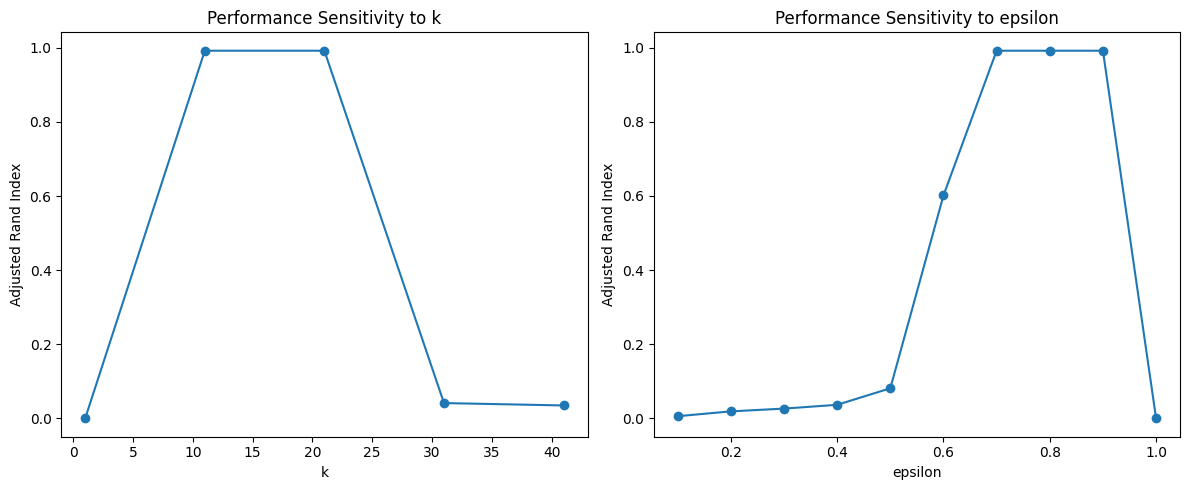

In [109]:
parameter_sensitivity()

From the left plot, which shows sensitivity to k, it appears that there is a peak performance at certain values of k k (somewhere between 5 and 15), after which the ARI sharply drops. This indicates that there's an optimal number of neighbors that allows the spectral clustering algorithm to best identify the true clusters. Too few neighbors and the graph might be too sparse to capture the true structure; too many and the graph might become too dense, connecting points from different clusters.

The right plot illustrates sensitivity to ϵ. We observe that the performance is low for small values of ϵ, rises sharply to perfect ARI as ϵ increases, and then remains stable across a range of ϵ
values before dropping at the largest value. This suggests that below a certain threshold, the ϵ-neighborhood is too small to connect all points within a cluster. As ϵ increases to an appropriate value, the clusters are well captured, leading to high ARI scores. If ϵ is too large, it may start to connect points from different clusters, thus reducing the ARI

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

If we did not have access to the true labels one way would have been to use some metrics that are density based such as the silhouette score or the inertia. However this only applies in the case were we have a data set is seperable and we have a dense representation of the points meaning that the clusters are clearly seperable and they are distributed accross the input space without overlapping. If we have a case where the is a spherical distribution one may use another technics, maybe considering one can consider a one class SVM to get which elements belongs to each class. The one class SVM being an unsupervised algorithm we don't need previous labels and may be used to distinguish clusters of points no matter their distribution through the choice of the right kernel

### Q3.2

To reduce the computational and occupational cost of Spectral Clustering, especially when dealing with large images and graphs with millions of nodes, here are two simple techniques:

Dimensionality Reduction: Instead of working directly with the full graph, apply dimensionality reduction techniques such as Principal Component Analysis (PCA) or t-distributed Stochastic Neighbor Embedding (t-SNE) to reduce the dimensionality of the data before constructing the graph. By reducing the number of dimensions, you can significantly reduce the computational complexity and memory requirements of Spectral Clustering.




Applying Subsampling: Rather than constructing the full graph between all pairs of pixels,  we can perform a grid sampling and averaging  this values we can get from that a sparser graphg  on which we can apply the sparser graph technics.Sparsifying the graph reduces the number of edges and hence decreases both computational and memory costs.



By applying these techniques, you can efficiently perform Spectral Clustering even on large images and graphs with millions of nodes, while mitigating the computational and occupational challenges associated with full graph construction.